In [1]:
import math
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [2]:
for dirname, _, filenames in os.walk('./data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

./data/test_round2.csv
./data/.DS_Store
./data/train_round2.csv
./data/graph_round2.csv
./data/test.csv
./data/graph.csv
./data/submission_round2.csv
./data/submission.csv
./data/train.csv


**Change the `data_dir` to the correct data set parent directory**

In [3]:
data_dir = "data"

In [4]:
train_data_path = os.path.join(data_dir, "train_round2.csv")
test_data_path  = os.path.join(data_dir, "test_round2.csv")
graph_data_path = os.path.join(data_dir, "graph_round2.csv")

**Load data sheets to `pandas.DataFrame()`**

In [6]:
train_data = pd.read_csv(train_data_path)
# train_data = train_data.loc[:,'ID':'Active']

train_data.head()

,ID,Province_State,Date,Confirmed,Deaths,Recovered,Active,Incident_Rate,People_Tested,People_Hospitalized,Mortality_Rate,Testing_Rate,Hospitalization_Rate
0,0,Alabama,04-12-2020,3563,93,NaN,3470.0,75.988020,21583.0,437.0,2.610160,460.300152,12.264945
1,1,Alaska,04-12-2020,272,8,66.0,264.0,45.504049,8038.0,31.0,2.941176,1344.711576,11.397059
2,2,Arizona,04-12-2020,3542,115,NaN,3427.0,48.662422,42109.0,NaN,3.246753,578.522286,NaN
3,3,Arkansas,04-12-2020,1280,27,367.0,1253.0,49.439423,19722.0,130.0,2.109375,761.753354,10.156250
4,4,California,04-12-2020,22795,640,NaN,22155.0,58.137726,190328.0,5234.0,2.812020,485.423869,22.961176


## Now let's visualize some <br>S.H.I.T. (Scatterplots and Histograms that Interpret the Trend)

In [7]:
# First, we will get the total confirmed/deaths of each state
states = list(np.unique(train_data['Province_State']))
collected = ['Confirmed', 'Deaths', 'People_Tested']
states_data = dict.fromkeys(states, None)
state_scaler = {}

for s in states:
    df_filter = train_data['Province_State'] == s
    state_df = train_data[df_filter]
    states_data[s] = state_df.drop(['Date','Deaths','Active','ID', 'Province_State', 'Incident_Rate', 'Recovered', 'People_Tested', 'People_Hospitalized', 'Mortality_Rate', 'Testing_Rate', 'Hospitalization_Rate'], 1)
    save_columns = states_data[s].columns
    state_scaler[s] = StandardScaler()
#     state_scaler[s] = MinMaxScaler()
    states_data[s] = state_scaler[s].fit_transform(states_data[s])
    states_data[s] = pd.DataFrame(states_data[s], columns=save_columns)
    
    

In [8]:
states_data['California']

,Confirmed
0,-1.364196
1,-1.360897
2,-1.356760
3,-1.352899
4,-1.350021
...,...
220,1.658917
221,1.697050
222,1.733562
223,1.779101


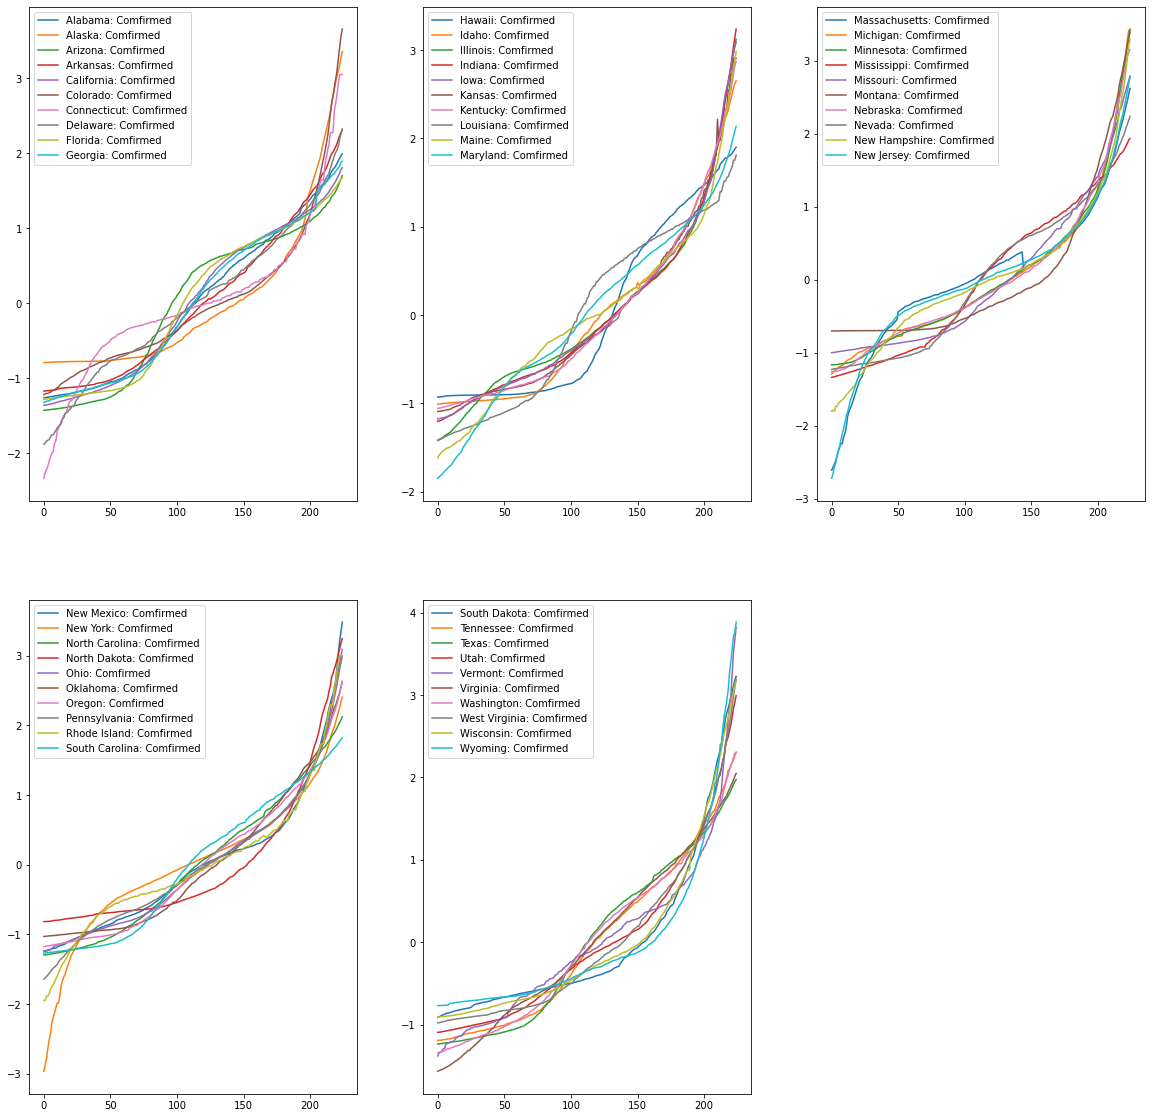

In [9]:
num_states = len(states_data.keys())
state_count = 1
figure_count = 1;
plt.figure(figsize=(20, 20))
for state in states_data.keys():
    if state_count == 1:
        plt.subplot(2,3,figure_count)
        plt.yscale('linear')
    plt.plot(states_data[state].Confirmed.values, label=f"{state}: Comfirmed")
    plt.legend(loc='best')
    state_count += 1
    if state_count == 11:
        state_count %= 10
        figure_count += 1
        
# plt.subplot(1,2,2)
# plt.plot(states_data['California'].Deaths.values, color='blue', label='Deaths')
# plt.legend(loc='best')


## Create Cross-validation Datasets

In [10]:
test_percentage = 1
validate_percentage = 0
state_train_data = {}
state_validate_data = {}

for state in states_data.keys():
    state_data_size = states_data[state].shape
    state_test_size = math.floor(state_data_size[0]*test_percentage)
    state_train_data[state] = states_data[state][:state_test_size]
    state_validate_data[state] = states_data[state][state_test_size:]

## Visualize the Trend of One State

AttributeError: 'DataFrame' object has no attribute 'Deaths'

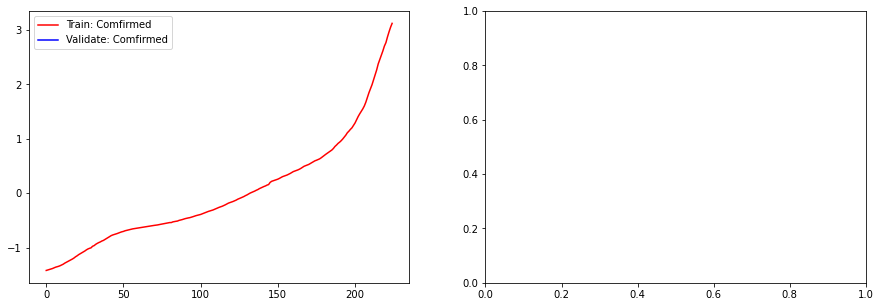

In [96]:
current_state = 'Illinois'
num_state_train = state_train_data[current_state].shape[0]
num_state_validate = state_validate_data[current_state].shape[0]
validate_range = np.arange(num_state_train, num_state_train+num_state_validate)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(state_train_data[current_state].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(validate_range, state_validate_data[current_state].Confirmed.values, color='blue', label='Validate: Comfirmed')
plt.legend(loc='best')
plt.subplot(1,2,2)
plt.plot(states_data[current_state].Deaths.values, color='blue', label='Train: Deaths')
plt.plot(validate_range, state_validate_data[current_state].Deaths.values, color='red', label='Validate: Deaths')
plt.legend(loc='best')

## Train a RNN Model with LSTM

In [189]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras import Sequential
from tensorflow.keras import Input
from tensorflow.keras.models import Model


# test model for current_state
data_training = np.array(state_train_data[current_state])

X_train = []
y_train = []

# window_size is use n-1 days to predict nth day
window_size = 22
forecast_days = 7

for i in range(data_training.shape[0] - window_size):
    X_train.append(data_training[i : i + window_size])
    y_train.append(data_training[i + window_size, 0])
    
X_train, y_train = np.array(X_train), np.array(y_train)

In [190]:
model = keras.Sequential()

model.add(LSTM(units=10, return_sequences=True, input_shape=(None, X_train.shape[2])))
model.add(Dropout(0.1))

model.add(LSTM(units=20, return_sequences=False))
model.add(Dropout(0.1))

model.add(Dense(units = 1))

model.summary()


Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, None, 10)          480       
_________________________________________________________________
dropout_3 (Dropout)          (None, None, 10)          0         
_________________________________________________________________
lstm_16 (LSTM)               (None, 20)                2480      
_________________________________________________________________
dropout_4 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 2,981
Trainable params: 2,981
Non-trainable params: 0
_________________________________________________________________


In [191]:
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1)

Train on 203 samples
Epoch 1/50
203/203 [==============================] - 8s 41ms/sample - loss: 0.8618
Epoch 2/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.6749
Epoch 3/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.4629
Epoch 4/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.2595
Epoch 5/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.1374
Epoch 6/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.1087
Epoch 7/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.1025
Epoch 8/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.0684
Epoch 9/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.0622
Epoch 10/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.0465
Epoch 11/50
203/203 [==============================] - 1s 3ms/sample - loss: 0.0425
Epoch 12/50
203/203 [==============================] - 1s 3ms/s

In [192]:
inputs = state_train_data[current_state].tail(window_size)
inputs = np.array(inputs)
prediction_queue = inputs.reshape(1,inputs.shape[0],1)
print(prediction_queue)
prediction_queue.shape

[[[1.45895459]
  [1.50340586]
  [1.54995752]
  [1.60381057]
  [1.67478828]
  [1.75910423]
  [1.84796389]
  [1.91947028]
  [1.995006  ]
  [2.08518734]
  [2.17561159]
  [2.26635733]
  [2.3764853 ]
  [2.45527163]
  [2.53122172]
  [2.61432315]
  [2.70434732]
  [2.76808795]
  [2.87247913]
  [2.96543957]
  [3.05039136]
  [3.12191917]]]


(1, 22, 1)

In [193]:
# prediction_queue should take in this y_pred as the last day and pop the first day in the queue
# use model.predict(prediction_queue) with the new prediction_queue to get second day.
# need to predict for next forecast_days days.

# y_peek = model.predict(prediction_queue)
# y_peek

for i in range(forecast_days):  
    y_pred = model.predict(prediction_queue)
    prediction_queue = np.append(prediction_queue, y_pred)
    prediction_queue = np.delete(prediction_queue, 0)
    prediction_queue = prediction_queue.reshape(1,prediction_queue.shape[0],1)
    
prediction_queue

array([[[1.91947028],
        [1.995006  ],
        [2.08518734],
        [2.17561159],
        [2.26635733],
        [2.3764853 ],
        [2.45527163],
        [2.53122172],
        [2.61432315],
        [2.70434732],
        [2.76808795],
        [2.87247913],
        [2.96543957],
        [3.05039136],
        [3.12191917],
        [3.18676543],
        [3.23865867],
        [3.28492403],
        [3.32585573],
        [3.36179185],
        [3.39303041],
        [3.41997623]]])

In [194]:
y_result = prediction_queue.flatten().tolist()
y_result = y_result[-forecast_days:]
y_result

[3.186765432357788,
 3.2386586666107178,
 3.284924030303955,
 3.3258557319641113,
 3.3617918491363525,
 3.3930304050445557,
 3.419976234436035]

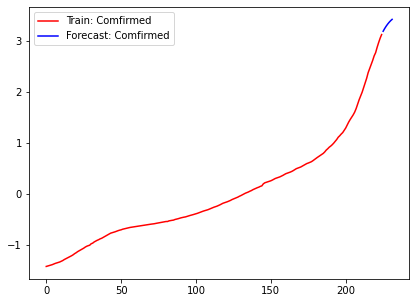

In [195]:
num_state_train = state_train_data[current_state].shape[0]
forecast_range = np.arange(num_state_train, num_state_train + forecast_day)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(state_train_data[current_state].Confirmed.values, color='red', label='Train: Comfirmed')
plt.plot(forecast_range, y_result, color='blue', label='Forecast: Comfirmed')
plt.legend(loc='best')

In [182]:
y_result = np.array(y_result) * state_scaler[current_state].scale_[0] + state_scaler[current_state].mean_[0]

In [183]:
y_result

array([643626.5069039 , 649725.05872732, 654974.35259392, 659517.28863618,
       663443.40469982, 666813.83881443, 669692.9994937 ])

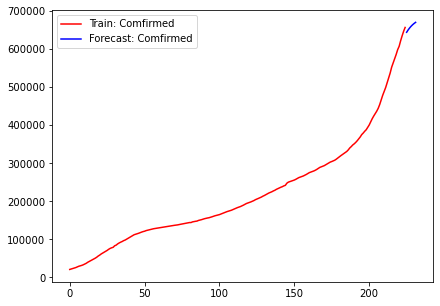

In [184]:
num_state_train = states_data[current_state].shape[0]
validate_range = np.arange(num_state_train, num_state_train+forecast_day)

plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.yscale('linear')
plt.plot(np.arange(num_state_train), states_data[current_state]['Confirmed']* state_scaler[current_state].scale_[0] + state_scaler[current_state].mean_[0], color='red', label='Train: Comfirmed')
plt.plot(validate_range, y_result, color='blue', label='Forecast: Comfirmed')
plt.legend(loc='best')

## Train a RNN with LSTM for Every State

In [24]:
num_states = len(states_data.keys())
initialization = np.zeros((forecast_day*num_states, 3))
result_df = pd.DataFrame(initialization, columns=['ForecastID', 'Confirmed', 'Deaths'], dtype='int')

def forcast(window_size, forecast_day, predict_label):
    predict_index = 0
    if predict_label == 'Deaths':
        predict_index = 1
        
    state_count = 0
    for state in states_data.keys():
        current_state = state
        num_state_train = state_train_data[current_state].shape[0]
        num_state_validate = state_validate_data[current_state].shape[0]
        validate_range = np.arange(num_state_train, num_state_train+num_state_validate)
        data_training = np.array(state_train_data[current_state])

        X_train = []
        y_train = []

        for i in range(window_size, data_training.shape[0]-forecast_day):
            X_train.append(data_training[i-window_size:i])
            y_train.append(data_training[i+forecast_day, predict_index])

        X_train, y_train = np.array(X_train), np.array(y_train)
        model = keras.Sequential()

        model.add(LSTM(units = 60, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], X_train.shape[2])))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 120, activation = 'relu', return_sequences = True))
        model.add(Dropout(0.2))

        model.add(LSTM(units = 200, activation = 'relu'))
        model.add(Dropout(0.2))

        model.add(Dense(units = 1))

        # model.summary()

        model.compile(optimizer='adam', loss = 'mean_squared_error')
        model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=0)

        previous_days = state_train_data[current_state].tail(window_size+forecast_day)
        inputs = np.array(previous_days)
        X_test = []
        y_test = []

        for i in range(window_size, inputs.shape[0]):
            X_test.append(inputs[i-window_size:i])
            y_test.append(inputs[i,predict_index])

        X_test, y_test = np.array(X_test), np.array(y_test)

        y_pred = model.predict(X_test)
        y_result = y_pred.flatten().tolist()
        y_result = np.array(y_result) * state_scaler[current_state].scale_[predict_index] + state_scaler[current_state].mean_[predict_index]

        date_count = 0
        for r in y_result:
            forecast_id = state_count + date_count * num_states
            result_df.loc[forecast_id]['ForecastID'] = forecast_id;
            result_df.loc[forecast_id][predict_label] = r;
            date_count += 1
        state_count += 1

In [25]:
forcast(7, 7, 'Confirmed')
forcast(7, 7, 'Deaths')

KeyboardInterrupt: 

In [ ]:
result_df.to_csv('./data/submission_round2.csv')